# IFT870 - Examen intratrimestriel

Auteur : Aurélien Vauthier (19 126 456)

In [348]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from difflib import SequenceMatcher
from tqdm import tqdm

# extract data
journal = pd.read_csv("api_journal11-13-17.csv", encoding="latin1")
price = pd.read_csv("api_price11-13-17.csv", index_col=0)
influence = pd.read_csv("estimated-article-influence-scores-2015.csv", index_col=0)

## Question 1 : Exploration-Description

*Présenter une description de chacun des attributs des 3 tables, avec des graphiques
pour la visualisation des statistiques descriptives au besoin.*

### Table `journal`

In [349]:
# show the first values
journal.head()

,issn,journal_name,pub_name,is_hybrid,category,url
0,0001-527X,Acta Biochimica Polonica,ACTA BIOCHIMICA POLONICA,0,MOLECULAR AND CELL BIOLOGY,NaN
1,0002-0397,Africa Spectrum,NaN,0,NaN,NaN
2,0003-0090,Bulletin of the American Museum of Natural His...,AMER MUSEUM NATURAL HISTORY,0,ECOLOGY AND EVOLUTION,NaN
3,0003-5521,L'anthropologie,Elsevier,1,Anthropology,NaN
4,0004-1254,Arhiv Za Higijenu Rada I Toksikologiju-Archive...,NaN,0,NaN,NaN


Nous pouvons déjà observer les colonnes suivantes et imaginer une petite description : 
- **issn** (valeur numérique) : ([International Standard Serial Number](https://fr.wikipedia.org/wiki/International_Standard_Serial_Number)),
il s'agit d'un numéro permettant d'identifier une série de publication de façon unique.
- **journal_name** (valeur catégorique) : Le nom du journal
- **pub_name** (valeur catégorique) : Le nom de l'éditeur
- **is_hybrid** (valeur booléenne) : (D'après le site [FlourishOA](http://flourishoa.org/about#type)) Permet de savoir
si le journal est hybride. C'est-à-dire, si le journal est à abonnement avec certains articles en accès libre.
- **category** (valeur catégorique) : La liste des catégories de la revue scientifique.
- **url** (valeur catégorique) : L'adresse web de la page d'acceuil du journal

In [350]:
#  Compute ratio of N/A values
(journal.isna().sum() / journal.shape[0]) * 100

issn             0.000000
journal_name     0.000000
pub_name        11.179557
is_hybrid        0.000000
category        48.148148
url             51.623698
dtype: float64

Nous pouvons remarquer que les colonnes `pub_name`, `category` et `url` possèdent des données manquantes. En particulier
`category` et `url` qui ont environs 50% de données manquantes.

In [351]:
# Compute ratio of unique values
print(f"Ratio de valeurs uniques pour l'index : {len(np.unique(journal.index)) / journal.shape[0]:.0%}")
print(f"Ratio de valeurs uniques pour issn : {journal['issn'].nunique() / journal.shape[0]:.0%}")

Ratio de valeurs uniques pour l'index : 100%
Ratio de valeurs uniques pour issn : 100%


L'index et les ISSN sont bien uniques.

La colonne `journal_name` ne semble pas avoir de problème mis à part quelques données dupliquées.

In [352]:
# sort and print the 10 biggest publishers
pub, count = np.unique(journal["pub_name"].dropna(), return_counts=True)
print("Nombre de revue par éditeur :")
for pub, count in sorted(zip(pub.tolist(), count.tolist()), key=lambda x: x[1], reverse=True)[:10]:
    print(f"\t- {pub} : {count} ({count/journal.shape[0]:.2%})")

Nombre de revue par éditeur :
	- Springer : 1886 (14.34%)
	- Hindawi Publishing Corporation : 487 (3.70%)
	- Elsevier : 294 (2.24%)
	- De Gruyter Open : 266 (2.02%)
	- BioInfo Publications : 142 (1.08%)
	- BioMed Central : 137 (1.04%)
	- Self Owned - Non-Profit Society : 127 (0.97%)
	- American Scientific Publishers : 119 (0.91%)
	- Biomed Central : 114 (0.87%)
	- Wiley : 104 (0.79%)


On peut voir qu'il existe de gros éditeurs, en particulier `Springer` qui publie 14.3% des revues scientifiques. 

In [353]:
# convert to bool values
journal["is_hybrid"] = journal["is_hybrid"].astype(bool)
print(f"Ratio de revues hybrides : {journal['is_hybrid'].sum() / journal.shape[0]:.2%}")

Ratio de revues hybrides : 13.19%


In [354]:
journal["category"][11065:11070]

11065    Medicine | Philosophy. Psychology. Religion
11066               Philosophy. Psychology. Religion
11067                       Music and books on Music
11068                                       Medicine
11069                        Language and Literature
Name: category, dtype: object

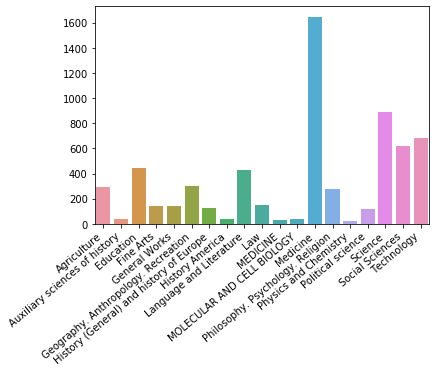

In [355]:
# show stats about categories
categories, cat_counts = np.unique(journal["category"].dropna(), return_counts=True)
categories = np.delete(categories, np.where(cat_counts < 20))
cat_counts = np.delete(cat_counts, np.where(cat_counts < 20))
sns.barplot(x=categories, y=cat_counts)
plt.xticks(rotation=40, ha="right")
plt.show()

Comme on peut le voir sur l'exemple ci-dessus, certaines revues possèdent plusieurs catégorie qui peuvent être séprarer
par plusieurs caractères comme `|`, `.` et `and`.

Finalement, pour la colonne `url`, il y a une grande partie de données manquantes mais 

### Table `price`

In [356]:
# show the first values
price.head()

,price,date_stamp,journal_id,influence_id,url,license
id,,,,,,
8691,1400.0,2016-08-11,2051-5960,NaN,NaN,NaN
8692,2175.0,2016-08-11,1758-9193,NaN,NaN,NaN
8693,2145.0,2016-08-11,1476-0711,NaN,NaN,NaN
8694,2145.0,2016-08-11,2047-2994,NaN,NaN,NaN
8695,2145.0,2016-08-11,1744-9081,NaN,NaN,NaN


Nous pouvons déjà observer les colonnes suivantes et imaginer une petite description :
- **price** (valeur continue) : Le prix de l'ACP (Article Publication Charge)
- **date_stamp** (valeur temporelle) : Horodatage représentant la date de création de l'entrée.
- **journal_id** (valeur catégorique) : Il s'agit de l'ISSN du journal
- **influence_id** (valeur catégorique) : On pourrait supposer qu'il s'agit d'un lien vers les lignes de la table
`influence` mais la majorité des id situés dans cette colonne sont supérieurs au nombre de lignes que possède la table
`influence` ce qui consititue alors des valeurs abérantes.
- **url** (valeur catégorique) : L'adresse web de la revue vers la page d'informations pour les auteurs.
- **license** (valeur catégorique) : Valeur numérique représentant une lisence (nous n'avons pas d'information sur la
correspondance entre les valeurs numériques et les différentes lisences qui existent.

In [357]:
#  Compute ratio of N/A values
(price.isna().sum() / price.shape[0]) * 100

price            0.000000
date_stamp       0.000000
journal_id       0.000000
influence_id    90.262989
url             95.330340
license         95.150738
dtype: float64

Nous pouvons remarquer que les colonnes `influence_id`, `url` et `license` possèdent presque uniquement des données
manquantes.

Statistiques de la colonne price :
- min : 0.00
- max : 7590.00
- moyenne : 1273.91
- varience : 1599684.20
- mode : 0.00


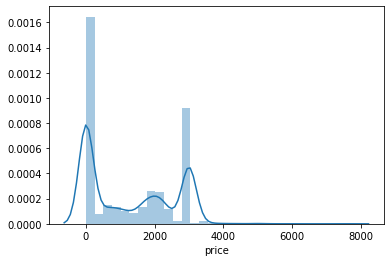

In [358]:
def show_continuous_col_stats(df, column):
    print(f"Statistiques de la colonne {column} :")
    print(f"- min : {df[column].min():.2f}")
    print(f"- max : {df[column].max():.2f}")
    print(f"- moyenne : {df[column].mean():.2f}")
    print(f"- varience : {df[column].var():.2f}")
    print(f"- mode : {df[column].mode()[0]:.2f}")
    sns.distplot(df[column].dropna())

show_continuous_col_stats(price, "price")

On remarque sur le graphique 4 groupes de prix des journaux. Un premier à 0, un deuxième entre 100 et 2900 environ, un
troisième autour de la valeur 3000 et finalement un dernier groupe au-dessus de 3100.

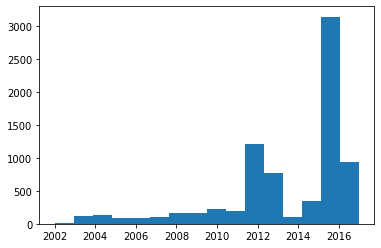

In [359]:
price["date_stamp"] = pd.to_datetime(price["date_stamp"], format="%Y-%m-%d")
groupedPrice = price["date_stamp"].groupby(price["date_stamp"].dt.year, sort=False)
years, years_count = [], []
for year in groupedPrice:
    years.append(year[0])
    years_count.append(year[1].shape[0])

plt.hist(years, bins=len(years), weights=years_count)
plt.show()

On note sur le graphique que la plupart des données ont été ajouté en 2016 et 2017, une autre partie fut ajouté en 2012
et 2013. La majorité des données est donc assez récente.

In [360]:
def multicolumn_duplicate_ratio(df, columns):
    flatten_array = df[columns].values.ravel('K')
    n_unique = len(pd.unique(flatten_array))
    return n_unique / df.shape[0]


# Compute ratio of unique values
print(f"Ratio de valeurs uniques pour journal_id : {price['journal_id'].nunique() / price.shape[0]:.0%}")
print(f"Ratio de valeurs uniques pour (journal_id, date_stamp) : {multicolumn_duplicate_ratio(price, ['date_stamp', 'journal_id']):.0%}")

Ratio de valeurs uniques pour journal_id : 73%
Ratio de valeurs uniques pour (journal_id, date_stamp) : 92%


Contrairement à la table `journal` il existe plusieurs duplicatas des ISSN, en effet, certaines revues scientifiques
ont eu des mise à jours de leurs informations.

In [361]:
# show ratio of incoherent values
print(f"Ratio de valeurs incohérentes pour influence_id : {1 - (price['influence_id'] <= influence.index[-1]).sum() / price.shape[0]:.2%}")

Ratio de valeurs incohérentes pour influence_id : 99.81%


La quasi-totalité des valeurs de `influence_id` sont soit manquantes soit ont une valeur supérieur à la valeur maximal
des id de la table `influence`. Cette colonne ne semble donc pas être utile.

In [362]:
print("Valeur(s) abérente(s) pour la colonne url :")
incoherent_influence_url = price[~price["url"].str.startswith("http", na=True)]
for index, row in incoherent_influence_url.iterrows():
    print(f"{index} : {row['url']}")

# remove incoherent values
for index in incoherent_influence_url.index:
    price.at[index, "url"] = np.NaN

Valeur(s) abérente(s) pour la colonne url :
13070 : FINANCE A UVER-CZECH JOURNAL OF ECONOMICS AND FINANCE


Bien qu'on ne retrouve qu'une seule valeur abérante, la majorité des valeurs reste manquente. Cela nuit donc fortement à
l'interêt de cette colonne.

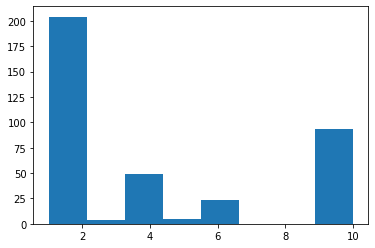

In [363]:
licenses, licenses_count = np.unique(price["license"].dropna(), return_counts=True)
plt.hist(licenses, bins=len(licenses), weights=licenses_count)
plt.show()

Comme nous pouvons le voir sur l'histogramme, la lisence 2 est majoritairement utilisée, on retrouve ensuite les
lisences 10, 4 et 6. Cependant, ne pouvant faire l'equivalence entre ces numéros et le nom des licenses (ou groupes de
lisences), les informations de cette colonne ne sont pas pertinentes. 

### Table `influence`

In [364]:
# show the first values
influence.head()

,journal_name,issn,citation_count_sum,paper_count_sum,avg_cites_per_paper,proj_ai,proj_ai_year
0,3d research,2092-6731,151.0,106.0,1.424528,0.290,2015
1,aaps pharmscitech,1530-9932,2208.0,801.0,2.756554,0.665,2015
2,abstract and applied analysis,1687-0409,3005.0,2923.0,1.028053,0.192,2015
3,academic psychiatry,1545-7230,537.0,490.0,1.095918,0.208,2015
4,academic questions,1936-4709,40.0,67.0,0.597015,0.097,2015


Nous pouvons déjà observer les colonnes suivantes et imaginer une petite description :
- **journal_name** (valeur catégorique) : Le nom du journal.
- **issn** (valeur catégorique) : L'ISSN du journal.
- **citation_count_sum** (valeur continue) : Le nombre de citation du journal.
- **paper_count_sum** (valeur continue) : Le nombre d'articles scientifiques du journal.
- **avg_cites_per_paper** (valeur continue) : La moyenne du nombre de citation par article du journal.
- **proj_ai** (valeur continue) : Le score d'influence associé à la moyenne des citations.
- **proj_ai_year** (valeur temporelle) : La date associé au calcul du score d'influence.

In [365]:
#  Compute ratio of N/A values
(influence.isna().sum() / influence.shape[0]) * 100

journal_name           0.00000
issn                   0.00000
citation_count_sum     0.33195
paper_count_sum        0.33195
avg_cites_per_paper    0.33195
proj_ai                0.33195
proj_ai_year           0.00000
dtype: float64

Il n'y a presque aucune données manquantes dans la table `influence`. De plus, les quatres seules colonnes en possédant
un peu, `citation_count_sum`, `paper_count_sum`, `avg_cites_per_paper` et `proj_ai`, ont exactement le même nombre de
données manquantes : 0.36%.

La colonne `journal_name` ne semble pas avoir de problème mis à part quelques données dupliquées.

In [366]:
# Compute ratio of unique values
print(f"Ratio de valeurs uniques pour l'index : {len(np.unique(influence.index)) / influence.shape[0]:.0%}")
print(f"Ratio de valeurs uniques pour issn : {influence['issn'].nunique() / influence.shape[0]:.0%}")

Ratio de valeurs uniques pour l'index : 100%
Ratio de valeurs uniques pour issn : 100%


L'index et les ISSN sont bien uniques.

Statistiques de la colonne citation_count_sum :
- min : 0.00
- max : 426949.00
- moyenne : 1446.71
- varience : 63949781.12
- mode : 636.00


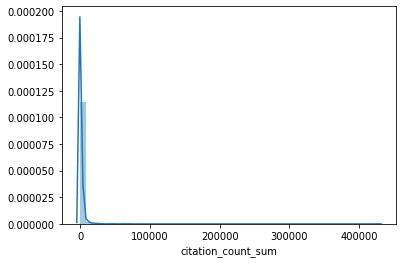

In [367]:
show_continuous_col_stats(influence, "citation_count_sum")

On peut noter un très grande dispertion des valeurs du nombre de citations qui peut faire pense à une distribution de
Poisson. De nombreux journaux n'ont pas beaucoup de citation (environs 636) alors que certains journaux se dispersent
entre des valeurs de 10 000 à 430 000 citations.

Statistiques de la colonne avg_cites_per_paper :
- min : 0.00
- max : 26.32
- moyenne : 2.12
- varience : 2.85
- mode : 1.75


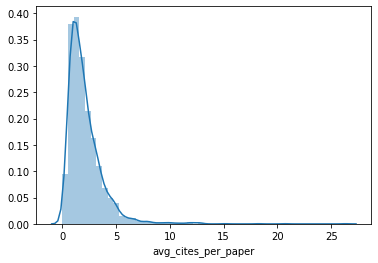

In [368]:
show_continuous_col_stats(influence, "avg_cites_per_paper")

Là encore la similarité avec la loi de Poisson est visible mais cette fois-ci la dispersion des données est bien moins
présente. On note tout de même un pic autour de la valeur 1.75 et des valeurs allant jusqu'à 27. 

Statistiques de la colonne proj_ai :
- min : 0.00
- max : 11.37
- moyenne : 0.52
- varience : 0.33
- mode : 0.38


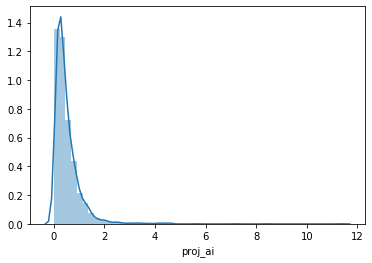

In [369]:
show_continuous_col_stats(influence, "proj_ai")

Cette colonne étant le résultat d'un rapport entre les deux dernières colonnes, il n'est pas très surprenant d'observer
une dernière fois la Loi de Poisson avec un mode autour de la valeur 0.4 et une dispertion jusqu'à 11.

In [370]:
print("Liste des valeurs uniques de proj_ai_year :")
for year in influence["proj_ai_year"].unique():
    print(f"\t- {year}")

Liste des valeurs uniques de proj_ai_year :
	- 2015


Surprenemment, nous pouvons noter que seule l'année 2015 est présente dans cette colonne.

## Question 2 : Prétraitement-Représentation

*Effectuer un prétraitement des données pour supprimer les duplications et corriger les
incohérences s’il y en a.*

### Table `journal`

On pourrait supposer que les ISSN permettent de définir une revue de façon unique, cependant, il existe de nombreuses
lignes dupliquées qui possèdent exactement les mêmes informations hormis leur ISSN. Il nous faut donc trouver un 
sous-ensemble de colonne qui nous permettrons de définir des duplicatas. 

Une deuxième hypothèse que nous pouvons faire est qu'un journal est représenté par son nom et qu'il est peu probable que
deux journaux différents possède le même nom. Nous allons donc considérer que deux lignes possédant le même nom de
journal sont des duplicatas. Pour différencier deux deuplicatas nous allons ensuite calculer un poids correspondant au
nombre de valeur non manquantes + 5 si la colonne `category` est non manquante. Ce choix de privilégier la colonne
`category` est fait de façon à privilégier les lignes avec cette colonne car elle sera importante pour les prédictions
des questions suivantes.

In [371]:
# Clean string columns
journal["issn"] = journal["issn"].str.strip()
journal["journal_name"] = journal["journal_name"].str.strip()
journal["pub_name"] = journal["pub_name"].str.strip()
journal["category"] = journal["category"].str.strip().str.lower()
journal["url"] = journal["url"].str.strip()

# remove duplicated values
not_na_count = journal.notnull().sum(axis=1)
row_to_keep = not_na_count.mask(journal["category"].notna(), not_na_count+5).groupby(journal["journal_name"]).idxmax()
journal = journal.loc[row_to_keep]

print(f"Nombre de lignes condérées comme dupliquées supprimées : {not_na_count.shape[0] - row_to_keep.shape[0]}")

# Replace inconsistant seperators by one so that we can seperate the values easily later
journal["category"] = journal["category"].str.replace(r"\s*([|.,&]|and)\s*", '|', regex=True)

Nombre de lignes condérées comme dupliquées supprimées : 1591


### Table `price`

Cette table étant une liste horodatée de prix pour un journal, nous pouvons donc utiliser le couple des colonnes 
`date_stamp` et `journal_id` pour chercher les duplicatas.

In [372]:
# Clean string columns
price["journal_id"] = price["journal_id"].str.strip()
price["url"] = price["url"].str.strip()

# Check duplicates
price[price.duplicated(subset=["date_stamp", "journal_id"]) & ~price.duplicated(subset=["date_stamp", "journal_id", "price"])]

,price,date_stamp,journal_id,influence_id,url,license
id,,,,,,
13073,2150.00,2017-05-17,0010-0277,NaN,https://www.elsevier.com/journals/cognition/00...,10.0
16473,387.15,2017-08-24,2397-5563,NaN,https://jpl.letras.ulisboa.pt/about/submission...,1.0


Seul un article possède un prix différent pour la même date (id `13073` et `16473`). En visitant le [site de la revue](https://jpl.letras.ulisboa.pt/about/submissions/)
on peut trouver la mention de publiction fee de £330. On peut donc considérer la deuxième ligne avec un prix affiché de
$387.15 comme étant la bonne ligne.

In [373]:
# Delete the wrong article found
price.drop(13073, inplace=True)

# Delete the other duplicates
price.drop_duplicates(subset=["date_stamp", "journal_id"], inplace=True)

Nous avions aussi trouvé une URL incohérente lors de la question 1 et l'avons déjà supprimé à ce moment là.

De plus, nous avions aussi trouvé de très nombreuses valeurs incohérentes dans la colonne `influence_id`. Par conséquent,
nous allons la supprimer. 

In [374]:
price.drop("influence_id", axis=1, inplace=True)

### Table `influence`

Pour cette table, à l'instar de `journal`, nous ne pouvons pas nous baser sur la colonne ISSN car plusieurs lignes sont
identiques si on exclu la vérification de l'ISSN.

In [375]:
# clean string columns
influence["journal_name"] = influence["journal_name"].str.strip()
influence["issn"] = influence["issn"].str.strip()

# drop duplicates
influence.drop_duplicates(subset=influence.drop("issn", axis=1).columns, inplace=True)

Finalement, la colonne `url` étant entièrement vide, il nous semble inutile de la garder. De plus, la colonne
`proj_ai_year` ne possède qu'une seule valeur non nulle, il nous semble donc peu utile de la garder aussi.

In [376]:
influence.drop("proj_ai_year", axis=1, inplace=True)

*Y a t il une corrélation entre les catégories de journaux (attribut « category ») et les
coûts de publication (attribut « price ») ? Justifier la réponse.*

Afin d'obtenir une corrélation plus précise nous pouvons essayer de ne garder qu'une ligne pour chaque journal. Ce
faisant nous gardons les prix les plus récent afin d'obtenir des statistiques plus à jour.

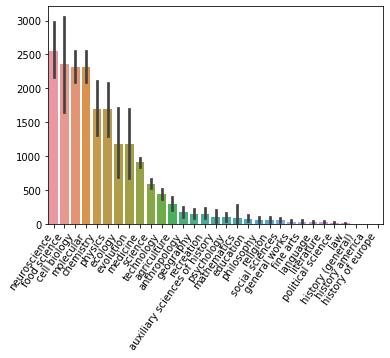

In [377]:
# merge tables with the desired columns
merge = journal.merge(price, left_on="issn", right_on="journal_id")

# sort by date stamp
merge.sort_values(by=["date_stamp"], ascending=False, inplace=True)

# only keep the first line of the duplicated journal name
merge.drop_duplicates(subset=["journal_name"], keep="first", inplace=True)

# drop unwanted columns
merge.drop(merge.drop(["category", "price"], axis=1).columns, axis=1, inplace=True)

# drop row where either the price or the category is missing
merge.dropna(inplace=True)

merge = pd.concat([merge, merge["category"].str.get_dummies()], axis=1)

correlations = []
for col in merge.drop(["category", "price"], axis=1).columns:
    group = merge[merge[col] == 1]
    if group.shape[0] >= 10:    # filter out the category with not much data
        correlations.append([col, group["price"].values])

# sort by prices' mean and extract values to list of cols and list of values
correlations = list(zip(*sorted(correlations, key=lambda corr: corr[1].mean(), reverse=True)))

sns.barplot(data=correlations[1])
plt.xticks(plt.xticks()[0], labels=correlations[0], rotation=55, ha="right")
plt.show()

Comme nous pouvons le voir sur le graphique ci-dessus, il semble que les catégories avec les prix les plus élevés soient
semble être lié aux différentes catégories des sciences (médecine, biologie, phisique, chimie...). A contrario, il
semble que les catégories avec les plus faibles prix soit tournent autours des arts, de la politique, de la litérature,
de l'histoire...

En résumé, nous pouvons dire que dans le cadre de nos données il existe une corrélation entre les colonnes `price` et
`category`.

*Construire un modèle pour prédire les valeurs de catégorie de journaux manquantes de
la façon la plus précise possible (cela inclut la sélection d’attributs informatifs, le
choix et le paramétrage d’un modèle de classification, le calcul du score du modèle,
l’application du modèle pour prédire les catégories manquantes). Justifier les choix
effectués.*

Pour prédire les valeurs des catégories nous allons utiliser les différentes statistiques présentes dans `influence` et
les prix présents dans `price`. Nous n'utiliserons cependant pas les données de `date_stamp` et de `is_hybrid` car ses
données ont plus un lien avec le prix qu'avec les catégories. Nous allons aussi calculer la distance entre les
catégories et les deux premières colonnes de `journal` (`journal_name` et `pub_name`). Pour cette distance, nous allons
calculer la longueur de la sous-chaine commune la plus longue et la diviser par la taille de la catégorie afin d'obtenir
un "pourcentage de ressemblance".

Pour le modèle, nous allons utiliser un `MultiOutputClassifier` (pour pouvoir prédire plusieurs catégories à un journal)
avec un `RandomForestClassifier` (pour bénéficier de la capacité des arbres décisionnels et de leur simplicité). Enfin,
pour les hyper-paramètres, nous allons utiliser un `GridSearchCV`.

In [378]:
# merge all data frames
merge = journal.merge(price, left_on="issn", right_on="journal_id").merge(influence, on="issn")
merge.rename(columns={"journal_name_x": "journal_name"}, inplace=True)

# drop unwanted columns
desired_cols = ["journal_name", "pub_name", "price", "citation_count_sum", "paper_count_sum", "avg_cites_per_paper",
                "proj_ai", "category"]
cat_model_data = merge.drop(merge.drop(desired_cols, axis=1).columns, axis=1)

# drop lines missing data used for prediction
desired_cols.remove("category") # we want to predict the missing categories at the end
cat_model_data.dropna(subset=desired_cols, inplace=True)

# compute training data targets
train_mask = cat_model_data["category"].notna()
cat_targets = cat_model_data[train_mask]["category"].str.get_dummies(sep='|')
cat_model_data.drop("category", axis=1, inplace=True)

# lower journal_name strings to make the string distance ignore cases
cat_model_data["journal_name"] = cat_model_data["journal_name"].str.lower()

# define the distance between a string (journal_name or pub_name) and a category
def category_dist(row, base_col, category):
    name = row[base_col]
    if name is np.NaN:
        return 0
    len_match = SequenceMatcher(a=name, b=category).find_longest_match(0, len(name), 0, len(category)).size
    return len_match / len(category)

# compute the journal_name and pub_name distances with the categories for the data
apply_category_dist = lambda df, base, cat: df.apply(category_dist, axis=1, base_col=base, category=cat)
for category in tqdm(cat_targets.columns, desc="Computing distances between (journal_name, pub_name) and the categories"):
    cat_model_data[f"journal_name_to_{category}_dist"] = apply_category_dist(cat_model_data, "journal_name", category)
    cat_model_data[f"pub_name_to_{category}_dist"] = apply_category_dist(cat_model_data, "pub_name", category)

# drop string columns
cat_model_data.drop(["journal_name", "pub_name"], axis=1, inplace=True)

Computing distances between (journal_name, pub_name) and the categories: 100%|██████████| 65/65 [00:15<00:00,  4.12it/s]


In [379]:
# define the hyper-parameter's grid search
param_grid = {
    "estimator__max_depth" : np.linspace(13, 15, 3, dtype=int),
    "estimator__n_estimators" : np.linspace(100, 200, 3, dtype=int)
}

# Create the model
rfc = RandomForestClassifier(n_jobs=-1)
moc = MultiOutputClassifier(rfc, n_jobs=-1)
cat_model = GridSearchCV(moc, cv=2, param_grid=param_grid, n_jobs=-1, verbose=1)

# Train model
X_train, X_test, y_train, y_test = train_test_split(cat_model_data[train_mask], cat_targets, test_size=0.2)
cat_model.fit(X_train, y_train)
print(f"Train accuracy : {cat_model.score(X_train, y_train):.2%}")
print(f"Test  accuracy : {cat_model.score(X_test, y_test):.2%}")
print(f"Best params : {cat_model.best_params_}")

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  18 | elapsed:  1.1min remaining:   19.1s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  1.7min finished


Train accuracy : 100.00%
Test  accuracy : 82.18%
Best params : {'estimator__max_depth': 15, 'estimator__n_estimators': 200}


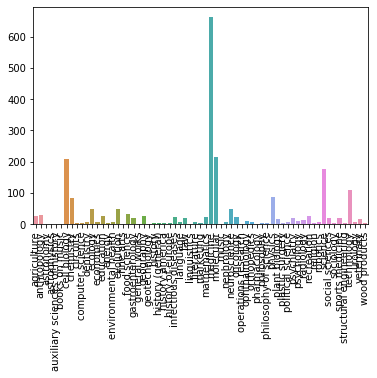

In [380]:
# Predict missing categories
predicted_cat = pd.DataFrame(cat_model.predict(cat_model_data), index=cat_model_data.index)

# show stats about predicted data
sns.barplot(x=cat_targets.columns, y=predicted_cat.sum(axis=0))
plt.xticks(rotation=90)
plt.show()

# replace line where the category in know by its representation in one hot
predicted_cat.mask(train_mask, cat_targets, inplace=True, axis=0)

# add the resulting data to the merge data
predicted_cat.reindex(merge.index)
predicted_cat.fillna(0.)    # these are the categories we could not predict because of missing data
merge = pd.concat([merge, predicted_cat], axis=1)

Comme on peut le voir sur le graphique la répartition des catégories prédites n'est pas consistante. On remarque en
particulier `medecine` qui est bien plus prédite que le reste et certaines catégorie ne semble pas être prédites une
seule fois. Malgré cela, le modèle obtient quand même un bon score de généralisation / de test. 

## Question 3 : Régression-Clustering

*Supprimer tous les attributs ayant plus de 50% de données manquantes.*

In [381]:
def drop_empty_columns(df, threshold=0.5):
    df.drop(df.columns[(df.isna().sum() / df.shape[0]) > threshold], axis=1, inplace=True)

for df in [journal, price, influence]:
    drop_empty_columns(df)

*Construire un modèle pour prédire le coût actuel de publication (attribut « price ») à
partir des autres attributs (cela inclut la sélection d’attributs informatifs, le choix et le
paramétrage d’un modèle de régression, le calcul du score du modèle, l’application du
modèle pour prédire les coûts). Justifier les choix effectués.
Lister les 10 revues qui s’écartent le plus (en + ou -) de la valeur prédite.*

Pour calculer les coûts actuels de publication, nous allons encore une fois utiliser les différents attributs de la
table `influence` et de `price`. À cela, nous allons aussi utiliser les catégories présentent dans `category` que nous
complèteront avec le modèle précédemment entrainé.

Pour le modèle de regression, nous allons cette fois-ci utiliser un `RandomForestRegressor` avec un `GridSearchCV` pour
la recherche des hyper-paramètres.

In [382]:
# drop unwanted columns
desired_cols = ["citation_count_sum", "paper_count_sum", "avg_cites_per_paper", "proj_ai", "is_hybrid", "price",
                "date_stamp"] + list(range(predicted_cat.shape[1])) # the one hots of the categories
price_model_data = merge.drop(merge.drop(desired_cols, axis=1).columns, axis=1)

# only keep the year for the date stamp
price_model_data["date_stamp"] = price_model_data["date_stamp"].apply(lambda date: date.year)

# drop lines missing data used for prediction
price_model_data.dropna(subset=desired_cols, inplace=True)

# compute training data targets
price_targets = price_model_data["price"]
price_model_data.drop("price", axis=1, inplace=True)

In [383]:
# define the hyper-parameter's grid search
param_grid = {
    "max_depth" : np.linspace(13, 17, 5, dtype=int),
    "n_estimators" : np.linspace(100, 200, 11, dtype=int)
}

# Create the model
rfr = RandomForestRegressor(n_jobs=-1)
price_model = GridSearchCV(rfr, cv=2, param_grid=param_grid, n_jobs=-1, verbose=1)

# Train model
X_train, X_test, y_train, y_test = train_test_split(price_model_data, price_targets, test_size=0.2)
price_model.fit(X_train, y_train)
print(f"Train accuracy : {price_model.score(X_train, y_train):.2%}")
print(f"Test  accuracy : {price_model.score(X_test, y_test):.2%}")
print(f"Best params : {price_model.best_params_}")

Fitting 2 folds for each of 55 candidates, totalling 110 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:    9.5s finished


Train accuracy : 96.91%
Test  accuracy : 82.43%
Best params : {'max_depth': 13, 'n_estimators': 180}


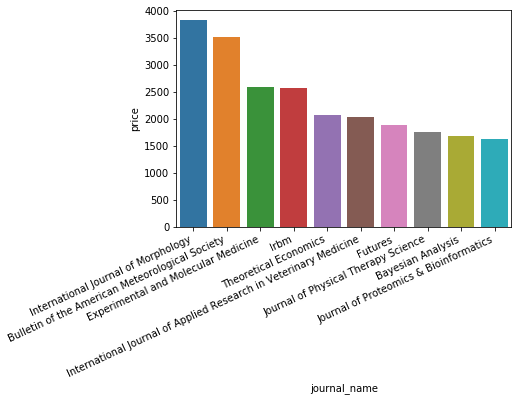

In [384]:
# Compute the absolute price difference
predicted_price = price_model.predict(price_model_data)
predicted_price -= price_targets
predicted_price = np.abs(predicted_price)
predicted_price = pd.Series(predicted_price, index=price_model_data.index).sort_values(ascending=False)

# plot the first ten worst predictions
sns.barplot(x=merge["journal_name"][predicted_price[:10].index], y=predicted_price[:10])
plt.xticks(rotation=25, ha="right")
plt.show()

Comme nous pouvons le constater sur le graphique ci-dessus, les 10 plus grandes erreurs de prédictions sont comprises
entre 2000 et 3000 en moyenne. Si on observe les données, nous pouvons nous rendre compte que les premières erreurs sont
souvent dû à des prédiction non nulle pour des journaux avec des prix nulle et inversement. Nous pouvons donc conclure
que notre modèle est suffisement précis pour prédir le prix moyen des journaux mais n'est pas encore capable
d'identifier des *outliers* qui proposent des prix bien différents des autres.

*Construire un modèle pour grouper les revues suivant le coût actuel de publication
(attribut « price ») et le score d’influence (attribut « proj_ai ») (cela inclut la
détermination du nombre de clusters, le choix et le paramétrage d’un modèle de
clustering, l’application du modèle pour trouver les clusters). Justifier les choix
effectués.*

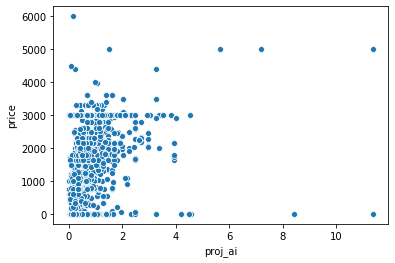

In [385]:
clustering_data = merge[["proj_ai", "price"]].dropna()
sns.scatterplot(x=clustering_data["proj_ai"], y=clustering_data["price"])

D'après le graphique, il semble exister un grand cluster de journaux avec des prix compris entre 0 et 3000 et avec un
score d'influence entre 0 et 2. A coté de ce cluster, nous pouvons observer de nombreux points plus ou moins isolés qui
pourrait être considérés comme des *outliers*.

Cette disposition des points semble indiquer que l'approche par K-means pourrait avoir comme résultat de diviser le
grand cluster et de regrouper les outliers avec les sous-clusters du grand cluster. Par conséquent, nous allons donc
nous interessé aux approches basé sur la densité. Nous allons aussi centrer et réduire les données.

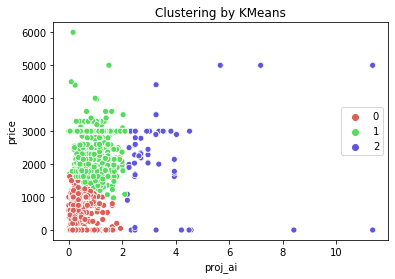

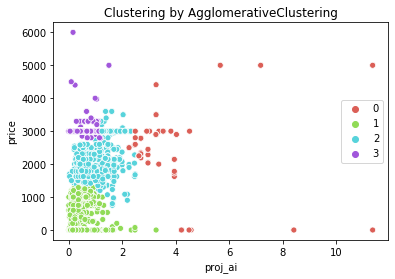

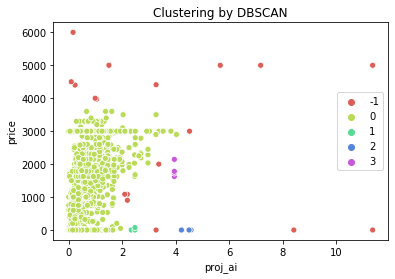

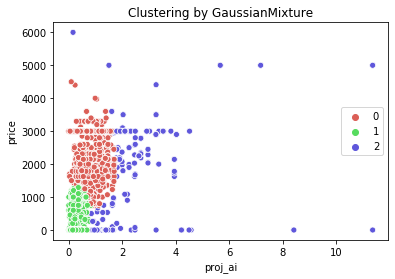

In [386]:
# Center and reduce data
clustering_model_data = StandardScaler().fit_transform(clustering_data)

# Create the models
clustering_models = [
    KMeans(n_clusters=3),
    AgglomerativeClustering(n_clusters=4, linkage="ward"),
    DBSCAN(eps=0.5, min_samples=5, n_jobs=-1),
    GaussianMixture(n_components=3, covariance_type="full")
]

# Run models, save and show results
predicted_clusters = []
for model in clustering_models:
    clusters = model.fit_predict(clustering_model_data)
    predicted_clusters.append(clusters)

    palette = sns.color_palette("hls", len(np.unique(clusters)))
    graph = sns.scatterplot(x=clustering_data["proj_ai"], y=clustering_data["price"], hue=clusters, palette=palette)
    graph.set_title(f"Clustering by {type(model).__name__}")
    plt.show()

Comme nous l'avions prévu, certains clusterings dissocie le grand ensemble de points en différents clusters. Seul
`DBSCAN` semble bien identifier un grand cluster, quelques petits clusters et plusieurs *outliers*.

*Présenter des statistiques descriptives des clusters obtenus, et lister les revues du
meilleur cluster en termes de rapport moyen : score d’influence / coût de publication.*

In [387]:

bestClusterIndex = None
bestClusterRatio = 0
for i, clusters in enumerate(predicted_clusters):
    clustering_data["clusters"] = clusters

    print(f"--- Statistiques du clustering de {type(clustering_models[i]).__name__} ---")
    for clusterId, cluster in clustering_data.groupby(["clusters"]):
        # skip outliers
        if clusterId == -1:
            continue

        print(f"\tCluster {clusterId} :")
        print(cluster[["price", "proj_ai"]].describe())

        mean_ratio = cluster['proj_ai'].mean() / (cluster['price'].mean() + 1e-3)
        print(f"Rapport moyen : {mean_ratio}")
        if mean_ratio > bestClusterRatio:
            bestClusterRatio = mean_ratio
            bestClusterIndex = cluster.index

        print()
    print()

# print the best journals according to its ration
print("Liste des meilleurs journaux selon leur rapport moyen :")
merge.iloc[bestClusterIndex][["journal_name", "pub_name"]]


--- Statistiques du clustering de KMeans ---
	Cluster 0 :
             price      proj_ai
count  1312.000000  1312.000000
mean    316.519291     0.365239
std     433.725041     0.296854
min       0.000000     0.000000
25%       0.000000     0.169000
50%       0.000000     0.270500
75%     670.500000     0.464500
max    1625.000000     1.935000
Rapport moyen : 0.001153918334070508

	Cluster 1 :
             price      proj_ai
count  2456.000000  2456.000000
mean   2562.403245     0.689178
std     552.206613     0.406652
min     950.000000     0.000000
25%    2145.000000     0.388750
50%    3000.000000     0.624000
75%    3000.000000     0.914000
max    6000.000000     2.130000
Rapport moyen : 0.00026895753584166743

	Cluster 2 :
             price    proj_ai
count    78.000000  78.000000
mean   2182.538462   3.711654
std    1397.814165   2.017615
min       0.000000   2.190000
25%    1637.500000   2.480750
50%    2329.500000   2.991500
75%    2975.000000   4.007250
max    5000.000000  11

,journal_name,pub_name
2268,Journal of Clinical Investigation,American Society for Clinical Investigation
2424,Journal of Machine Learning Research,Microtome Publishing
2425,Journal of Machine Learning Research,Microtome Publishing
2614,Journal of Statistical Software,Foundation for Open Access Statistics
2615,Journal of Statistical Software,Foundation for Open Access Statistics
2616,Journal of Statistical Software,Foundation for Open Access Statistics
2617,Journal of Statistical Software,Foundation for Open Access Statistics
